# Introduction

In the previous blog post, we implemented Lenet-5, which was released in 1998. The Lenet series of models were extremely good for the task of digit recognition. However, the MNIST dataset was relatively small, both in terms of total images and the number of classes available. Training neural nets for other more complicated tasks on larger datasets would have taken an infeasibly long time on CPUs. Other machine learning approaches, like support vector machines, which were feasible to train, gained prominence during this time.

The next big breakthrough for deep learning came in 2012, with the release of AlexNet. Jointly authored by Alex Krizhevsky, after whom the model is named, with Ilya Sutskever and Geoffrey Hinton, AlexNet won the Imagenet competition in 2012 by a very big margin, ~10% in error rate, demonstrating that deep learning approaches could be the state-of-the art in complicated computer vision tasks. 

In this post, we will reimplement the AlexNet architecture with close reference to the original paper. We will try to stay as faithful to the published version as possible, but wherever we deviate, we will be careful to document it. The major discovery of AlexNet, which we will try to convey, is that training deep neural networks with many layers could dramatically increase performance, and the compute required to train neural networks of interesting depth could be provided by graphics programming units (GPUs).

In [ ]:
# Import packages
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from torch.utils import data
import torch.multiprocessing


import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from livelossplot import PlotLosses

# The ImageNet object recognition task

The ImageNet dataset consists of 1.5 million images labelled with 1000 different classes. A famous machine learning competition called the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) asks submissions to recognize or in other words classify an image into the different classes. 

The primary metrics that the competition used were the top-5 error and top-1 error, which are defined respectively as follows: the submissions can make up to 5 predictions per image from the 1000 classes, and a top-5 error is defined to have happened when the correct class is not present in these predictions. The top-1 error is equivalent to the accuracy: the submissions can make one prediction per image from the 1000 classes, and a top-1 error is defined to have happened when the correct class is not equal to this prediction.

In [ ]:
def get_dataset(IMG_DIR, transforms_list):
    """
    Get dataset
    """
    return datasets.ImageFolder(IMG_DIR, transforms.Compose(transforms_list))

In [ ]:
def get_dataloader(dataset, BATCH_SIZE, shuffle=True, 
                   pin_memory=True, num_workers=4, 
                   drop_last=True, subset_data=False, 
                   N_SAMPLE=None):
    """
    Get data-loader
    """
    if subset_data == True:
        assert N_SAMPLE is not None
        subset = random.sample(range(len(dataset)), N_SAMPLE)
        dataset = data.Subset(dataset, subset)

    return data.DataLoader(
                    dataset,
                    shuffle=shuffle,
                    pin_memory=pin_memory,
                    num_workers=num_workers,
                    drop_last=drop_last,
                    batch_size=BATCH_SIZE)

ImageNet was considered a very hard dataset, because classical machine learning methods were not able to do well at this task. In the next section, we'll start explaining the architecture and the innovations in the paper which made this jump in performance possible.

# AlexNet architecture

ImageNet is so large that reaching good performance on object recognition requires a model far deeper, with more layers and more filters per layer, than had been trained at the time. The AlexNet architecture consists of five convolutional layers followed by three fully connected layers, which seems small by today's standards but was very large by the standards of that time. Training this architecture on a CPU or even a single GPU for long enough to reach a good level of performance was infeasible with the hardware then available. The designers of AlexNet realized that they would have to get creative to get good results, and so they came up with many tricks to speed up training, some of which we talk about below.

In [ ]:
class AlexNet(nn.Module):
    
    def __init__(self, num_classes):
        
        super(AlexNet, self).__init__()

        self.net = nn.Sequential(
            # 3 * 224 * 224
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), 
            # Size: (224 + 2*2 - 8) / 2 + 1 = (110 + 1) = 111
            # 64 * 111 * 111
            nn.ReLU(inplace=True),
            # 64 * 111 * 111
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Size: (111 + 2*0 - 3) / 1 + 1 = (108 + 1) = 109
            # 64 * 109 * 109 
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            # Size: (109 + 2*2 - 5) / 1 + 1 = (108 + 1) = 109
            # 64 * 109 * 109
            nn.ReLU(inplace=True),
            # Size: (109 + 2*2 - 5) / 1 + 1 = (108 + 1) = 109
            # 64 * 109 * 109
            nn.MaxPool2d(kernel_size=3, stride=2), 
            # Size: (109 + 2*0 - 3) / 2 + 1 = (53 + 1) = 54
            # 128 * 54 * 54
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            # Size: (54 + 2*1 - 3) / 1 + 1 = (53 + 1) = 54
            # 128 * 54 * 54
            nn.ReLU(inplace=True),
            # Size: (54 + 2*1 - 3) / 1 + 1 = (53 + 1) = 54
            # 256 * 54 * 54
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            # Size: (54 + 2*1 - 3) / 1 + 1 = (53 + 1) = 54
            # 256 * 54 * 54
            nn.ReLU(inplace=True),
            # Size: (54 + 2*1 - 3) / 1 + 1 = (53 + 1) = 54
            # 256 * 54 * 54
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            # Size: (54 + 2*1 - 3) / 1 + 1 = (53 + 1) = 54
            # 256 * 54 * 54
            nn.ReLU(inplace=True),
            # Size: (54 + 2*1 - 3) / 1 + 1 = (53 + 1) = 54
            # 256 * 54 * 54
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Size: (54 - 3) / 2 + 1 = (53 + 1) = 54
            # 256 * 54 * 54
            ) 
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096), 
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes)
            )

        self.init_weights()


    def init_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.1)
                nn.init.constant_(layer.bias, 0)
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.1)
                nn.init.constant_(layer.bias, 1)

        nn.init.constant_(self.net[3].bias, 1)
        nn.init.constant_(self.net[6].bias, 1)
        nn.init.constant_(self.net[8].bias, 1)


    def forward(self, x):
        x = self.net(x)
        return self.classifier(x)

# Speeding up training: model parallelism

One main innovation of the paper was coming up with a way to do parallel training across two GPUs. The authors designed a model parallelism scheme. Model parallelism refers to placing different parts of a model's architecture on different machines and training them in parallel. In AlexNet, inputs to deeper layers come only from those layers which reside on the same GPU. For example, layer 4 takes input only from those layer 3 kernels which are on the same machine.

A second innovation contributed by the authors was writing highly efficient implementations of all the operations required in the architecture in CUDA, the API for interacting with NVIDIA GPUs. At the time of writing, this code is still available on Alex Krizhevsky's website. The authors had realized that GPUs could be leveraged to make training feasible for deeper architectures, and that making optimal use of the hardware available would be key. This is why the authors put a lot of effort into getting the GPU code right.

Throughout the paper, the authors have to balance the need for depth and training time with the computational resources available to them. That tension between scaling up compute while retaining efficiency has become a theme of deep learning research that continues until today.  

# Speeding up training: rectified linear unit (ReLU)

AlexNet was amongst the first major models to use the ReLU activation function, instead of the sigmoid or tanh functions which were commonly used in deep learning models at that time. The ReLU activation function allows for learning to occur at any positive value of the activation. The sigmoid or tanh functions have lower gradients at extreme values, which leads to a relatively higher proportion of 'dead' neurons which are not contributing to learning. The graph below exhibits this.

In [ ]:
def activation_plot(start, end, step):
    """
    Activation plot
    """
    x = torch.arange(start,end, step)
    sigmoid = nn.Sigmoid()(x)
    tanh = nn.Tanh()(x)
    relu = nn.ReLU()(x)
    
    i = 1
    for y in [sigmoid, tanh, relu]:
        plt.plot(x, y, c=cdict[i], label=labels[i])
        i+=1
    
    plt.legend()
    plt.show()

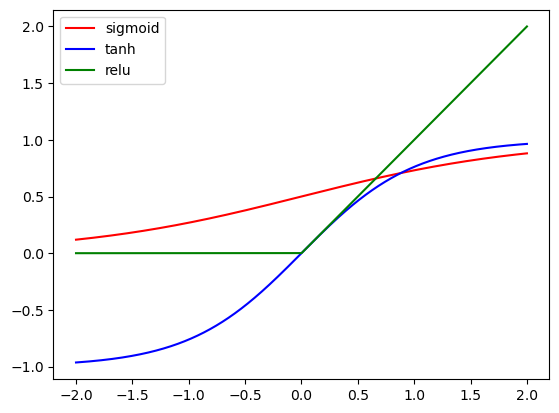

In [ ]:
start = -2
end = 2
step = 1e-4

cdict = {1: 'red', 2: 'blue', 3: 'green'}
labels = {1: 'sigmoid', 2: 'tanh', 3: 'relu'}

activation_plot(start, end, step)

What does it mean to say a neuron is dead? It means that the particular neuron is not contributing a significant amount to the steps taken by the optimizer. Suppose we are training a model using stochastic gradient descent, like the authors of AlexNet did. The update formula is given as follows: 

$W^{(l)} \leftarrow W^{(l)} - \eta \frac{\partial L}{\partial W^{(l)}}$

From the chain rule: 

$\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial a^{(l)}} \times \frac{\partial a^{(l)}}{\partial W^{(l)}}$



From the formulas, we see that the step size is determined by two quantities: the learning rate $\eta$ and the gradient of the loss with respect to the weights $\frac{\partial L}{\partial W^{(l)}}$. Using the chain rule, the gradient of the loss with respect to the weights is the gradient of the activation with respect to the weight $\frac{\partial a^{(l)}}{\partial W^{(l)}}$ times the gradient of the loss with respect to the activation $\frac{\partial L}{\partial a^{(l)}}$. 

If the activation function has a small gradient with respect to the weights, that reduces the contribution of that particular neuron to the overall step taken by the optimizer for a fixed learning rate and fixed activation function. At extreme values of the activation, look at the graph above - the gradients of the sigmoid and tanh are very small! This leads to a lower learning rate and slower training.

The ReLU function is designed to address this problem, and the paper shows evidence from experiments that this actually works. Another interesting way to solve this problem is to use learning rates which vary throughout the training as a function of the epoch number, and also across layers, depending on how many neurons are 'dying'. Maybe there will another blog post which covers this set of very cool ideas.

# Preventing overfitting: dropout

Given that the authors were training a model with more layers than was usual for that time, the other concern was to control overfitting. Overfitting in machine learning refers to a situation where a model learns to 'memorize' the training data so closely that it does not generalize well to unseen validation or test data. The solution is to use regularization, or in other words, restrict the complexity of the model, to force it to learn only those features or weights which are actually useful in performing the task that is being solved. 

One interesting regularization method is dropout. Training ensembles of models, or in other words multiple architectures, had been shown by that time to generalize better for many different kinds of machine learning models. However, for a neural network like this, which was already taking days to train, training multiple architectures was infeasible. 

Dropout had at the time been recently proposed as a way to simulate an ensemble. In dropout, hidden layer neuron outputs are randomly set to 0 with probability 0.5. This randomly deactivates certain neurons per layer in both the forward and backward pass, and so with each iteration, the training procedure is effectively using a different architecture. This also ensures that the remaining neurons do not co-adapt to each other - each neuron which survives the dropout layer in a given forward pass is forced to learn more robust and relevant features in conjunction with other random subsets of neurons, so it does not become too specialized. At test time, the output of each hidden layer neuron is multiplied by 0.5, and no neurons are discarded. This is so that the test time prediction distribution matches the training time distribution.

# Preventing overfitting: data augmentation

Data augmentation is a second technique used by the paper. The ImageNet images are high resolution 256 X 256 images. The authors cut out random 226 X 226 center patches from the image and perform two types of augmentation: 1) translations and inversions, and 2) changing the color and illumination of each extracted patch according to a particular scheme that they define. This increases the size of the training data by a factor of 2048x, though obviously there is a high correlation between many of the resulting samples. The paper reports that the model severely overfits without data augmentation. At test time, the model makes predictions on five 226 X 226 patches. These are the four corner patches of that size and the center patch.

To change the color and illumination, the paper uses a scheme where it takes all the RGB pixel values across the training set, calculates the principle components via PCA, multiplies the found principle components by a quantity which is directly proportion to the corresponding eigenvalue times a single draw from a standard Guassian. This procedure approximately captures that object identity does not change with the color and illlumination of the picture. This is complicated to implement so for now we let it be, but maybe I will return to this blog post in the future and make this update.

# Training utilities

We are finally nearly ready for training. We define some useful utility functions below. There are two aspects of the training which are from the paper. 

# Training: stochastic gradient descent with weight Decay
Firstly, the paper uses stochastic gradient descent with a weight decay of 0.00005. The paper mentions that this is actually important for learning and not just regularization because it results in a lower training error, apart from controlling overfitting / validation error.


# Training: learning rate schedule
Secondly, the paper uses a schedule where the learning rate is reduced by 10x whenever the validation loss does not improve for ten epochs. We use these settings just because they are the ones used in the paper, even though as described above our dataset is different. Apart from these two configurations, the other functions just perform useful tasks like model loading and saving, and setting the device to use a GPU if one is available.

In [ ]:
def set_seed():
    """
    Set random seed
    """
    return torch.initial_seed()


def get_model(NUM_CLASSES, device, model_name):
    """
    Setup model
    """
    if model_name == 'alexnet':
        return AlexNet(num_classes=NUM_CLASSES).to(device)


def set_device():
    # Set devices to be agnostic to whether CPU or GPU is used
    if torch.cuda.is_available():
        return torch.device('cuda') 
    # Mac M1
    elif torch.backends.mps.is_available():
        return torch.device('mps') 
    else:
        return torch.device('cpu')


def save_checkpoint(model_name, CHECKPOINT_DIR, epoch, 
                   total_steps, optimizer, model, seed, history):
    """
    Save checkpoint
    """
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'{model_name}_best_loss.pkl')
    state = {'model': model.state_dict()}
    torch.save(state, checkpoint_path)


def get_optimizer(optimizer_name, model, other_params):
    """
    Create optimizer
    """
    params = model.parameters()
    return optim.SGD(params, **other_params)


def set_lr_schedule(optimizer, step_size=1, gamma=0.1, policy_name='Step', step_size_up=10, base_lr=0.01, max_lr=0.4):
    """
    Set LR scheduler
    """
    if policy_name == 'Step':
        return optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif policy_name == 'Cyclic':
        return optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)

# Training loop

In [ ]:
def training_loop(LOG_DIR, NUM_CLASSES, model_name, 
                  DEVICE_IDS, TRAIN_IMG_DIR, VAL_IMG_DIR, transforms_list,
                  BATCH_SIZE, N_SAMPLE, optimizer_name, other_params, NUM_EPOCHS,
                  N_CHECK, CHECKPOINT_DIR):
    """
    This is the main
    training and evaluation
    loop for the model
    """
    logs = PlotLosses()
    
    # Misc. settings to make sure no errors happen
    torch.autograd.set_detect_anomaly(True)

    # Prevents out of memory error when num_workers > 1 in data loaders
    torch.multiprocessing.set_sharing_strategy('file_system')
    
    # Set backend
    device = set_device()
    cpu_device = torch.device('cpu')
    print("Using the following device:")
    print(device)

    # Make directory to store checkpoints
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    # Print the seed value
    seed = set_seed()
    print('Used seed : {}'.format(seed))

    # Create model
    model = get_model(NUM_CLASSES, device, model_name)
    print('Model instance created')

    # Create datasets and data loaders
    train_dataset = get_dataset(TRAIN_IMG_DIR, transforms_list)
    print('Train dataset created')
    
    
    val_dataset = get_dataset(VAL_IMG_DIR, transforms_list)
    print('Val dataset created')
    

    train_loader = get_dataloader(train_dataset, BATCH_SIZE, 
                                  shuffle=True, pin_memory=True, 
                                  num_workers=4, drop_last=True, 
                                  subset_data=False, N_SAMPLE=None)




    train_evaluator = get_dataloader(train_dataset, len(train_dataset), 
                                     shuffle=True, pin_memory=True, 
                                     num_workers=4, drop_last=True, 
                                     subset_data=False, N_SAMPLE=None)

    for i, data in enumerate(train_evaluator):
        X_train, Y_train = data
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)


    val_loader = get_dataloader(val_dataset, len(val_dataset), 
                                shuffle=True, pin_memory=True, 
                                num_workers=4, drop_last=True, 
                                subset_data=False, N_SAMPLE=None)



    for i, data in enumerate(val_loader):
        X_val, Y_val = data
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)
    

    # Print 
    print('Dataloaders created')

    optimizer = get_optimizer(optimizer_name, model, other_params)
    print('Optimizer created')


    # Multiply LR by 1 / 10 after every 30 epochs
    lr_scheduler = set_lr_schedule(optimizer, step_size=30, gamma=0.1)
    print('LR Scheduler created...')

    # Start training!
    total_steps = 1
    print('Starting training...')

    # Set whether to run in test mode
    test = False

    # Define the loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # Initialize the dictionary where all metrics will be stored
    history = {
        'acc': [],
        'loss': [], 
        'val_acc': [],
        'val_loss': []
    }

    # Training loop
    if not test:

        min_val_loss = np.inf
        # Train for maximum number of epochs given here
        for epoch in tqdm(range(NUM_EPOCHS)):
            # Initialize running loss value for this epoch
            running_loss = 0.0
            # Loop through the generator containing training images
            for i, data in enumerate(train_loader):
              # Retrieve inputs and labels
              inputs, labels = data
              # Send them to GPU 
              inputs = inputs.type(torch.FloatTensor).to(device)
              # Labels
              labels =  labels.type(torch.LongTensor).to(device)
              # Zero the optimizer gradients
              optimizer.zero_grad()
              # Forward propagation
              outputs = model.forward(inputs)
              # Compute loss
              loss = loss_fn(outputs, labels)
              # Backward propogation
              loss.backward()
              # Weight update
              optimizer.step()
      
            # Compute training loss
            with torch.no_grad():
              # Forward propagation
              out = model.forward(X_train)
              # Prediction 
              preds = out.argmax(axis=1)
              # Get accuracy 
              accuracy = sum(preds == Y_train)/len(Y_train)
              # Get loss 
              loss = loss_fn(out, Y_train)
              # Append to history record
              history['acc'].append(accuracy.to(cpu_device))
              # Append loss to history record
              history['loss'].append(loss.to(cpu_device))

          
            # Compute validation loss
            with torch.no_grad():
              # Forward propogation
              out = model.forward(X_val)
              # Prediction 
              preds = out.argmax(axis=1)
              # Calculate accuracy
              accuracy = sum(preds == Y_val)/len(Y_val)
              # Calculate loss 
              loss = loss_fn(out, Y_val)
              # Append accuracy to history record
              history['val_acc'].append(accuracy.to(cpu_device))
              # Append loss
              history['val_loss'].append(loss.to(cpu_device))

            # If loss has improved
            if loss < min_val_loss:
              # Save checkpoint
              save_checkpoint(model_name, CHECKPOINT_DIR, epoch, 
                              total_steps, optimizer, model, seed, history)
              # Minimum validation loss
              min_val_loss = loss
            
            metrics = {k: v[-1] for k, v in history.items()}
            logs.update(metrics)
            logs.send()

# Execution

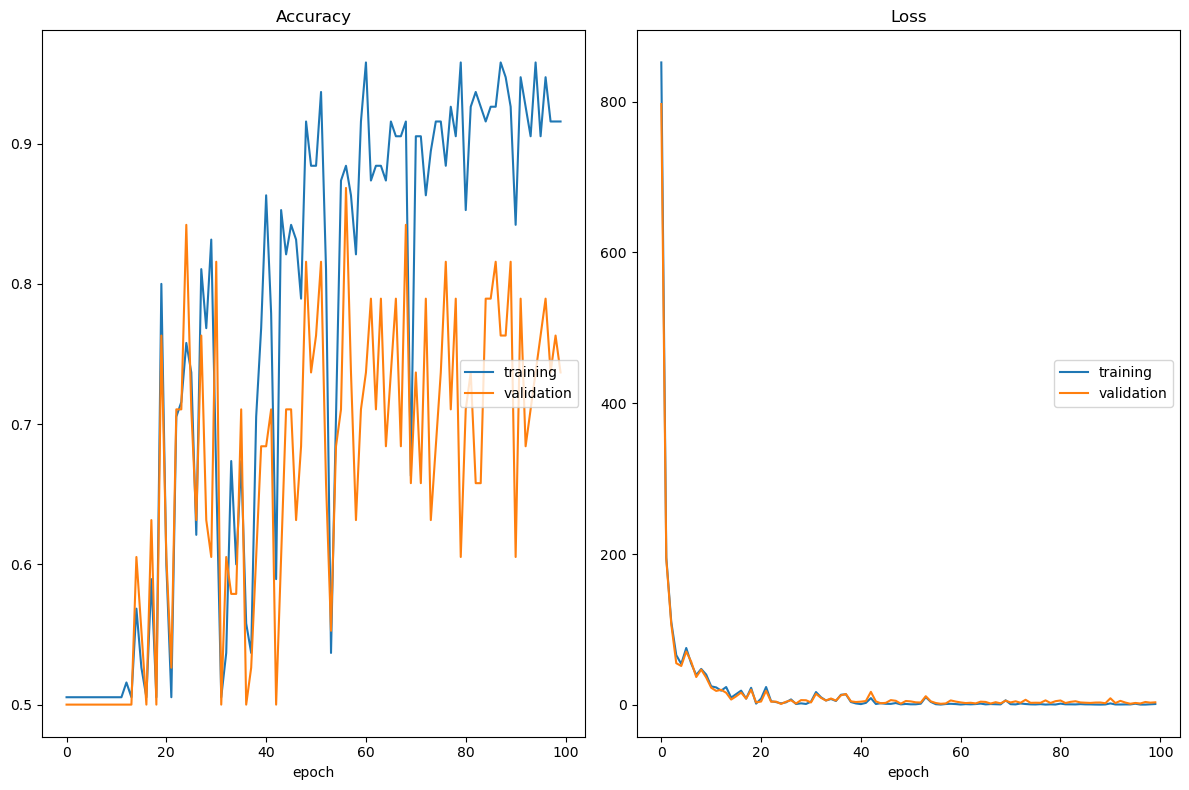

100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [26:32<00:00, 15.93s/it]

Accuracy
	training         	 (min:    0.505, max:    0.958, cur:    0.916)
	validation       	 (min:    0.500, max:    0.868, cur:    0.737)
Loss
	training         	 (min:    0.274, max:  851.907, cur:    1.041)
	validation       	 (min:    1.141, max:  796.738, cur:    3.314)


In [ ]:
if __name__ == '__main__':

    MODEL_NAME = 'alexnet'
    DATA_ROOT = 'data'
    DATASET_NAME = 'imagenette2_sample'
    
    INPUT_ROOT_DIR = os.path.join(DATA_ROOT, DATASET_NAME)
    OUTPUT_DIR = os.path.join(DATA_ROOT, f'{MODEL_NAME}_data_out')
    
    TRAIN_IMG_DIR = os.path.join(INPUT_ROOT_DIR, 'train')
    VAL_IMG_DIR = os.path.join(INPUT_ROOT_DIR, 'val')
    
    LOG_DIR = os.path.join(OUTPUT_DIR, 'tblogs')
    CHECKPOINT_DIR = os.path.join(OUTPUT_DIR , 'models')
    
    NUM_EPOCHS = 100  
    BATCH_SIZE = 32
    MOMENTUM = 0.9
    LR_DECAY = 0.01
    LR_INIT = 0.0001
    N_SAMPLE = 100
    N_CHECK = 5
    IMAGE_DIM = 227
    NUM_CLASSES = 2
    DEVICE_IDS = None
    MEANS = [0.485, 0.456, 0.406]
    STDS = [0.229, 0.224, 0.225]
    
    OPTIMIZER_NAME = 'SGD'
    OTHER_PARAMS = {'lr': LR_INIT, }

    TRANSFORMS_LIST = [transforms.CenterCrop(IMAGE_DIM),
                       transforms.ToTensor(),
                       transforms.Normalize(mean=MEANS, std=STDS),]

    training_loop(LOG_DIR, NUM_CLASSES, MODEL_NAME, 
                  DEVICE_IDS, TRAIN_IMG_DIR, VAL_IMG_DIR, TRANSFORMS_LIST,
                  BATCH_SIZE, N_SAMPLE, OPTIMIZER_NAME, OTHER_PARAMS, NUM_EPOCHS, N_CHECK, CHECKPOINT_DIR)
    

# Conclusion

There you have it - AlexNet almost how it was implemented in the original paper. There are still a few components missing which I may come back and add in the future: 
 
 * We use max-pooling instead of the local response normalization used by the authors. 
 
 * The data augmentation scheme is missing, even though the authors explicitly say that AlexNet suffers from terrible overfitting without it. This is reflected in our own results with how jagged the validation accuracy curve is.
 
 *  There is no model parallelism implemented here because we don't have multiple machines and in any case the hardware available to us is powerful enough to do training in a short amount of time on our reduced version of ImageNet.
 
 *  The learning rate schedule is different from what was used in the paper so it may be interesting to see the effects of changing this to be the same as in the paper.

The effects of AlexNet were far-reaching: The authors showed that GPU hardware could be effectively used to train neural networks of greater depth than had been possible up until then. They only used 2 NVIDIA GPU cards, which obviously got everyone interested in the possibilities of using more compute to train deeper models! More importantly, they showed that this greater depth was not pointless, but actually resulted in performance that smashed all the existing records on the ImageNet object recognition dataset. 

This opened the door for deep learning research to start flourishing in the area of computer vision. Alex Krizhevsky and Ilya Sutskever, who then had a startup called DNN Inc. to conduct their neural network experiments, got acquired by Google. What came next? Deeper models and more explorations of how to scale up neural network size and complexity. Stay tuned for more in the next blog posts.